# Video Conference Attention Detection

**Author:**
- Ayaz Maredia
- Divy Goswami
- Kartik Prajapati
- Krish Patel
- Parth Sathiya


These are the libraries that needs to be install.

In [1]:
# !pip install opencv-python

In [2]:
# !pip install tensorflow

In [3]:
# !pip install deepface

In [4]:
# !pip install mediapipe

In [5]:
# !pip install pandas

In [6]:
# !pip install seaborn

In [7]:
import torch

In [8]:
print(torch.cuda.is_available())

True


In [9]:
import pandas as pd
df = pd.read_csv('HL_all_attention_results.csv')
df.head()

df.head()

Serial No                                         Image Name  \
0          1  78236e192c1171c149c14253a66ea628_1920x1080_30_...   
1          2  4d8ffedc816b405fe0187bd03392664f_1920x1080_30_...   
2          3  f7fe11d9c406c810f79b21e8c793bb99_1080x1920_30_...   
3          4  6c9c96d33030b3b3879c691760492b14_1920x1080_30_...   
4          5  3bcfd30cdb997ccb70af3559078a6ccc_1920x1080_30_...   

  Computer Label                                         Image Path  \
0      Attentive  ./dataset/All_extracted_frames/78236e192c1171c...   
1  Not Attentive  ./dataset/All_extracted_frames/4d8ffedc816b405...   
2      Attentive  ./dataset/All_extracted_frames/f7fe11d9c406c81...   
3  Not Attentive  ./dataset/All_extracted_frames/6c9c96d33030b3b...   
4  Not Attentive  ./dataset/All_extracted_frames/3bcfd30cdb997cc...   

                                           Drive URL  Image Preview  \
0  https://drive.google.com/uc?export=view&id=1ZW...            NaN   
1  https://drive.google.com/uc?export=view&id=1Iq...            NaN   
2  https://drive.google.com/uc?export=view&id=1nQ...            NaN   
3  https://drive.google.com/uc?export=view&id=1uA...            NaN   
4  https://drive.google.com/uc?export=view&id=1TZ...            NaN   

     Human Label  
0      Attentive  
1  Not Attentive  
2      Attentive  
3      Attentive  
4      Attentive

In [10]:
df['Computer Label'].value_counts()

Computer Label
Attentive        1342
Not Attentive    1058
Name: count, dtype: int64

In [11]:
df['Human Label'].value_counts()

Human Label
Attentive        1648
Not Attentive     752
Name: count, dtype: int64

Selected 5 random images for visualization

Processing 1/5: 38a41875b10cf12852ac9a06b2f9c7af_1920x1080_30_frame0120.jpg


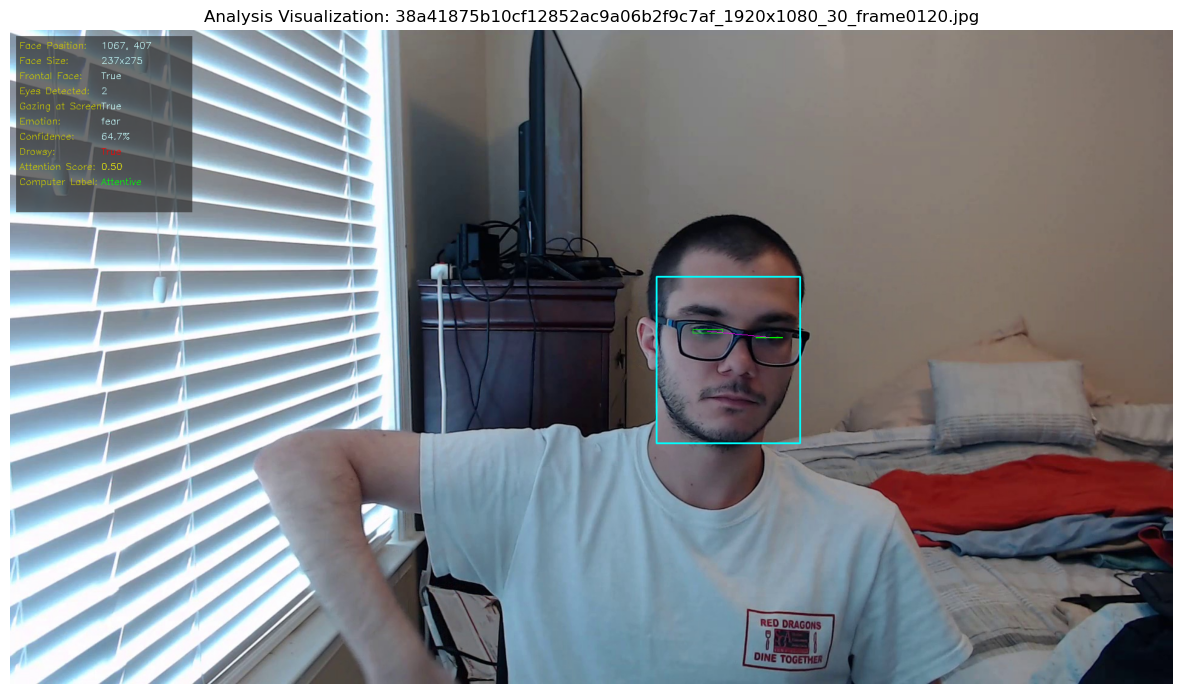


Processing 2/5: 104c931a5ea4b6b0b9dc2240a109a3d0_1920x1080_30_frame0240.jpg


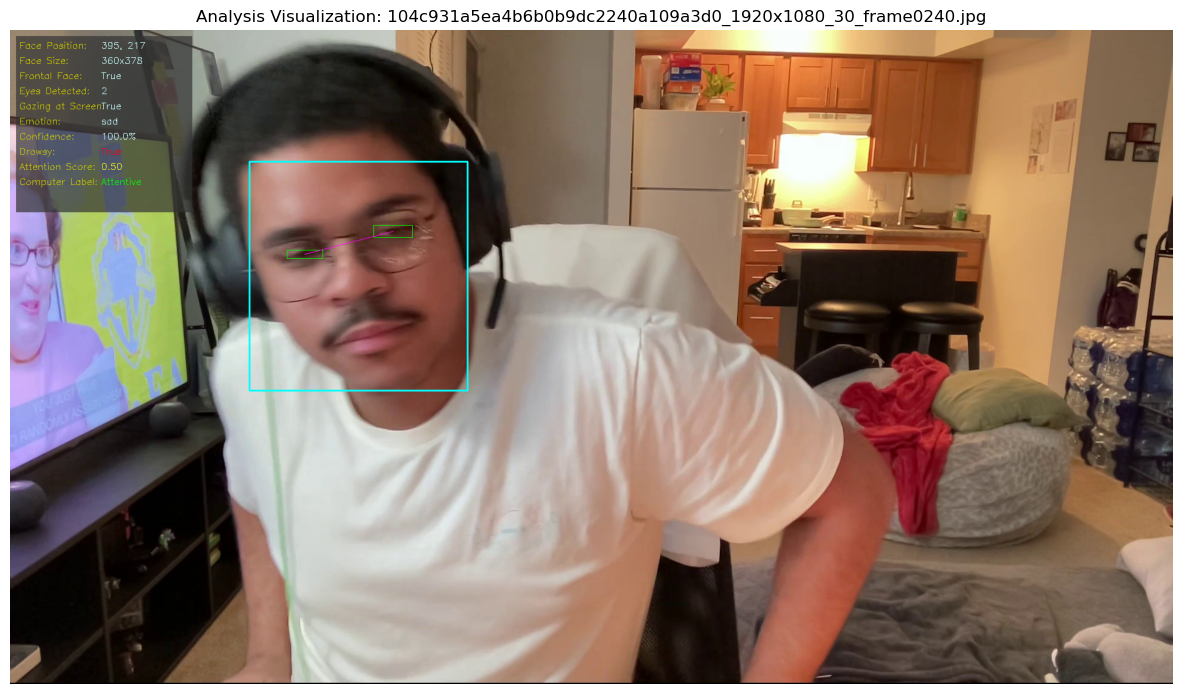


Processing 3/5: 87a1bfcf25e7aef4e0f2cd72b518b1a1_1920x1080_30_frame0020.jpg


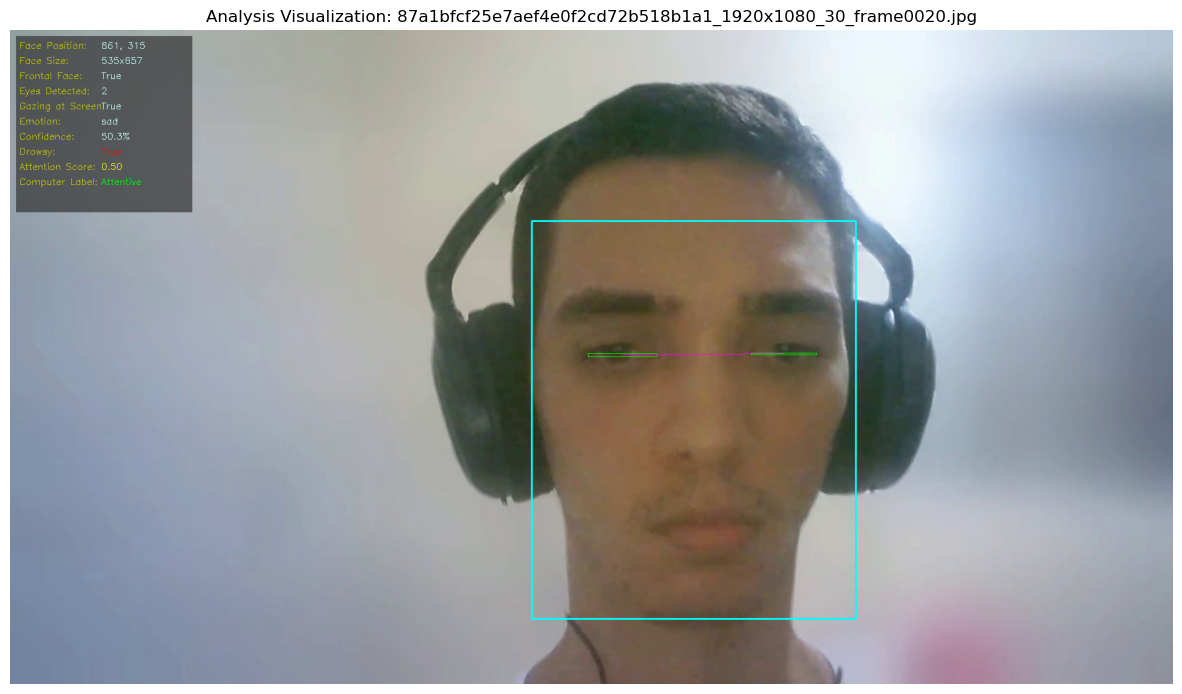


Processing 4/5: 70a45f44a21a1d3a18d046e41acb497d_1080x1920_30_frame0260.jpg


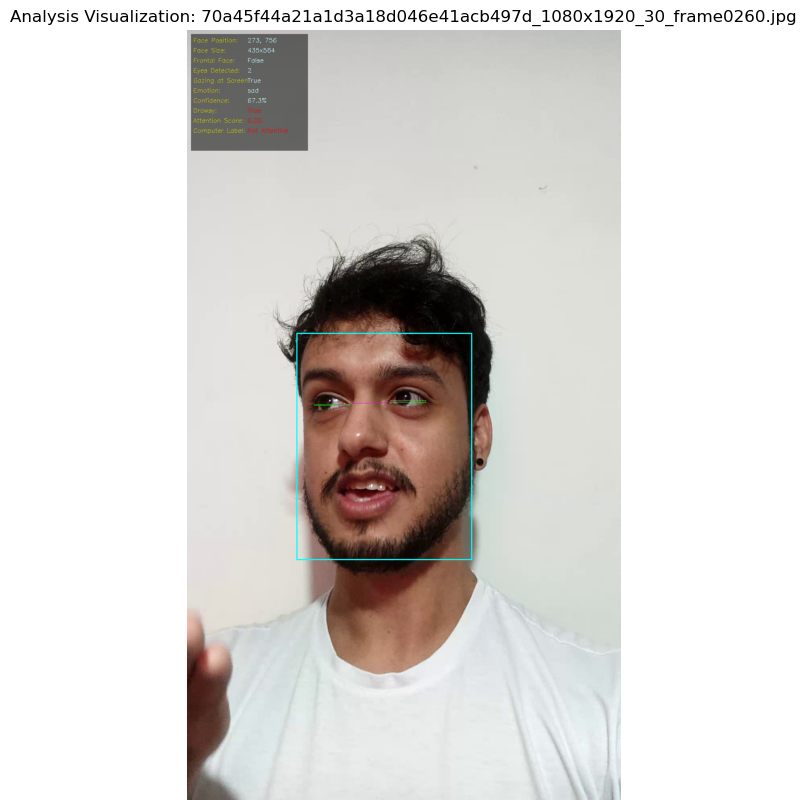


Processing 5/5: 6b72ba8a8da1988e25b8ac483be81575_1920x1080_30_frame0280.jpg


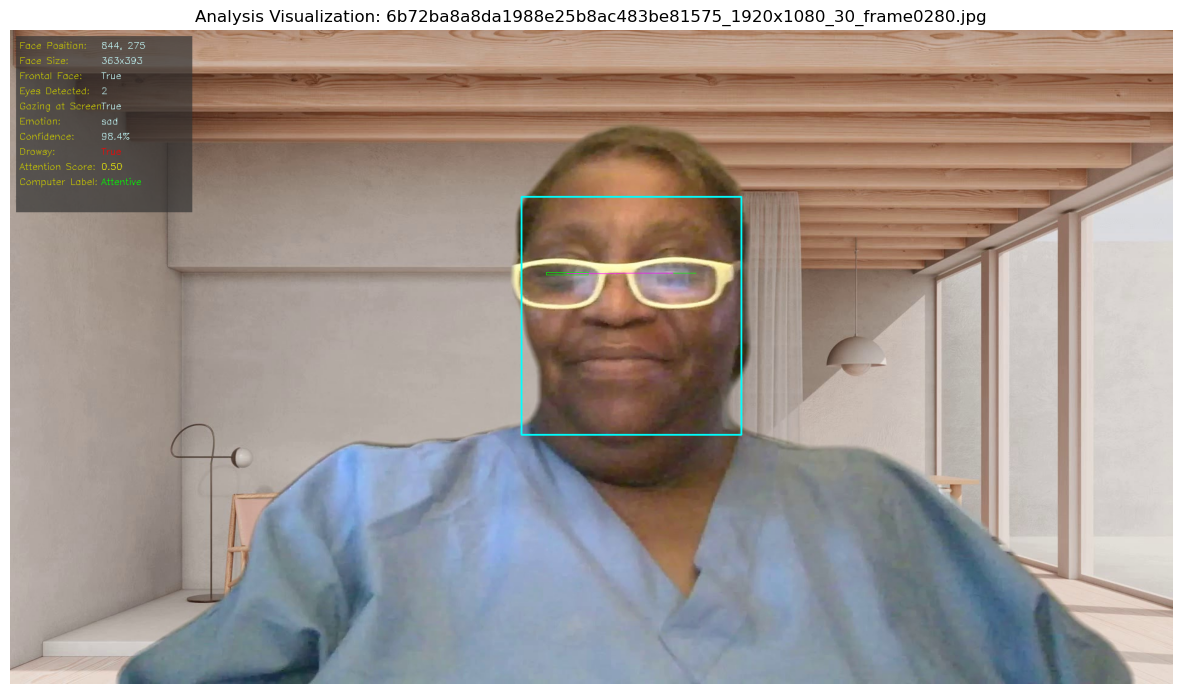


Visualization complete! Processed 5 random images
Saved visualizations to ./visualized_results/


In [12]:
# This code help us to visualize the image based on the detected feature along with matrix that defines "Attentive or Not Attentive"
import cv2
import os
import json
import random
import numpy as np
from matplotlib import pyplot as plt

# Configuration
results_file = 'all_attention_results.json'
image_folder = './dataset/All_extracted_frames/'
output_folder = './visualized_results/'
num_images_to_visualize = 5  # Number of random images to visualize
display_first_n = 5  # Number of images to display in notebook

# Create output directory
os.makedirs(output_folder, exist_ok=True)

# Color definitions
COLORS = {
    'face': (0, 255, 255),        # Yellow
    'eyes': (0, 255, 0),          # Green
    'gaze_line': (255, 0, 255),   # Purple
    'text': (255, 255, 255),      # White
    'attention_high': (0, 255, 0), # Green
    'attention_med': (255, 255, 0),# Yellow
    'attention_low': (255, 0, 0),  # Red
    'metric_label': (200, 200, 0), # Light yellow
    'metric_value': (200, 255, 255) # Light cyan
}

# Load results
with open(results_file) as f:
    results = json.load(f)

# Create a dictionary mapping image names to their results
result_dict = {result['image_name']: result for result in results}

# Get list of all available images
all_images = [f for f in os.listdir(image_folder)
             if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Filter to only images that have analysis results
valid_images = [img for img in all_images if img in result_dict]

# Randomly select images
random.seed(42)  # For reproducibility
selected_images = random.sample(valid_images, min(num_images_to_visualize, len(valid_images)))

def visualize_result(result):
    """Draw visualization with all metrics on the image"""
    img_path = os.path.join(image_folder, result['image_name'])
    img = cv2.imread(img_path)
    if img is None:
        print(f"Could not read image: {result['image_name']}")
        return None

    # Convert to RGB for matplotlib
    img_viz = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_h, img_w = img_viz.shape[:2]

    # Draw face bounding box
    if result.get('face'):
        face = result['face']
        cv2.rectangle(img_viz,
                     (face['x'], face['y']),
                     (face['x'] + face['width'], face['y'] + face['height']),
                     COLORS['face'], 2)

    # Draw eyes and gaze line
    if result.get('eyes') and len(result['eyes']) >= 2:
        eye1 = result['eyes'][0]
        eye2 = result['eyes'][1]

        # Eye bounding boxes
        for eye in result['eyes']:
            cv2.rectangle(img_viz,
                         (eye['x'], eye['y']),
                         (eye['x'] + eye['width'], eye['y'] + eye['height']),
                         COLORS['eyes'], 1)

        # Gaze line
        cv2.line(img_viz,
                (eye1['center'][0], eye1['center'][1]),
                (eye2['center'][0], eye2['center'][1]),
                COLORS['gaze_line'], 1)

    # Create metrics panel
    y_start = 30
    line_height = 25
    panel_width = 300

    # Draw semi-transparent panel
    overlay = img_viz.copy()
    cv2.rectangle(overlay, (10, 10), (panel_width, 300), (50, 50, 50), -1)
    cv2.addWeighted(overlay, 0.7, img_viz, 0.3, 0, img_viz)

    # Display all metrics
    def put_metric(label, value, y_pos, value_color=COLORS['metric_value']):
        cv2.putText(img_viz, f"{label}:",
                   (15, y_pos), cv2.FONT_HERSHEY_SIMPLEX, 0.5, COLORS['metric_label'], 1)
        cv2.putText(img_viz, f"{value}",
                   (150, y_pos), cv2.FONT_HERSHEY_SIMPLEX, 0.5, value_color, 1)

    y_pos = y_start

    # Face metrics
    if result.get('face'):
        face = result['face']
        put_metric("Face Position", f"{face['x']}, {face['y']}", y_pos)
        y_pos += line_height
        put_metric("Face Size", f"{face['width']}x{face['height']}", y_pos)
        y_pos += line_height
        put_metric("Frontal Face", str(face['is_frontal']), y_pos)
        y_pos += line_height

    # Eye metrics
    if result.get('eyes'):
        put_metric("Eyes Detected", str(len(result['eyes'])), y_pos)
        y_pos += line_height
        if len(result['eyes']) >= 2:
            put_metric("Gazing at Screen", str(result.get('gazing_at_screen', False)), y_pos)
            y_pos += line_height

    # Emotion metrics
    if result.get('emotion'):
        put_metric("Emotion", result['emotion'], y_pos)
        y_pos += line_height
        put_metric("Confidence", f"{result['emotion_confidence']*100:.1f}%", y_pos)
        y_pos += line_height

    # Drowsiness
    if 'is_drowsy' in result:
        drowsy_color = COLORS['attention_low'] if result['is_drowsy'] else COLORS['attention_high']
        put_metric("Drowsy", str(result['is_drowsy']), y_pos, drowsy_color)
        y_pos += line_height

    # Attention score
    if 'attention_score' in result:
        attention_color = COLORS['attention_high'] if result['attention_score'] > 0.7 else \
                         COLORS['attention_med'] if result['attention_score'] > 0.4 else \
                         COLORS['attention_low']
        put_metric("Attention Score", f"{result['attention_score']:.2f}", y_pos, attention_color)
        y_pos += line_height

    # Computer label
    if 'computer_label' in result:
        label_color = COLORS['attention_high'] if result['computer_label'] == 'Attentive' else COLORS['attention_low']
        put_metric("Computer Label", result['computer_label'], y_pos, label_color)
        y_pos += line_height

    return img_viz

# Process selected images
print(f"Selected {len(selected_images)} random images for visualization")
for i, img_name in enumerate(selected_images, 1):
    result = result_dict[img_name]
    print(f"\nProcessing {i}/{len(selected_images)}: {img_name}")

    img_viz = visualize_result(result)
    if img_viz is None:
        continue

    # Save visualization
    output_path = os.path.join(output_folder, f"viz_{img_name}")
    cv2.imwrite(output_path, cv2.cvtColor(img_viz, cv2.COLOR_RGB2BGR))

    # Display first few results
    if i <= display_first_n:
        plt.figure(figsize=(15, 10))
        plt.imshow(img_viz)
        plt.axis('off')
        plt.title(f"Analysis Visualization: {img_name}")
        plt.show()

print("\n" + "="*80)
print(f"Visualization complete! Processed {len(selected_images)} random images")
print(f"Saved visualizations to {output_folder}")
print("="*80)

# Data Preprocessing

In [13]:
df.head()

Serial No                                         Image Name  \
0          1  78236e192c1171c149c14253a66ea628_1920x1080_30_...   
1          2  4d8ffedc816b405fe0187bd03392664f_1920x1080_30_...   
2          3  f7fe11d9c406c810f79b21e8c793bb99_1080x1920_30_...   
3          4  6c9c96d33030b3b3879c691760492b14_1920x1080_30_...   
4          5  3bcfd30cdb997ccb70af3559078a6ccc_1920x1080_30_...   

  Computer Label                                         Image Path  \
0      Attentive  ./dataset/All_extracted_frames/78236e192c1171c...   
1  Not Attentive  ./dataset/All_extracted_frames/4d8ffedc816b405...   
2      Attentive  ./dataset/All_extracted_frames/f7fe11d9c406c81...   
3  Not Attentive  ./dataset/All_extracted_frames/6c9c96d33030b3b...   
4  Not Attentive  ./dataset/All_extracted_frames/3bcfd30cdb997cc...   

                                           Drive URL  Image Preview  \
0  https://drive.google.com/uc?export=view&id=1ZW...            NaN   
1  https://drive.google.com/uc?export=view&id=1Iq...            NaN   
2  https://drive.google.com/uc?export=view&id=1nQ...            NaN   
3  https://drive.google.com/uc?export=view&id=1uA...            NaN   
4  https://drive.google.com/uc?export=view&id=1TZ...            NaN   

     Human Label  
0      Attentive  
1  Not Attentive  
2      Attentive  
3      Attentive  
4      Attentive

In [14]:
df.columns

Index(['Serial No', 'Image Name', 'Computer Label', 'Image Path', 'Drive URL',
       'Image Preview', 'Human Label'],
      dtype='object')

For better accuracy, we did human labeling which better classified the frame to attentive or not attentive.
for that we equally distrubuted the extracted image file stored in dataset folder using Google sheet amongst our team member.
Team member classified images based on below given aspects
- face detection
- eye detection
- Face facing front to the camera
- eye gazing in the screen
- Hand gesture
- Distraction or not distracted
- Is drowsy or Not Drowsy

Columns in your CSV: ['Serial No', 'Image Name', 'Computer Label', 'Image Path', 'Drive URL', 'Image Preview', 'Human Label']
Classes in dataset: ['Attentive' 'Not Attentive']


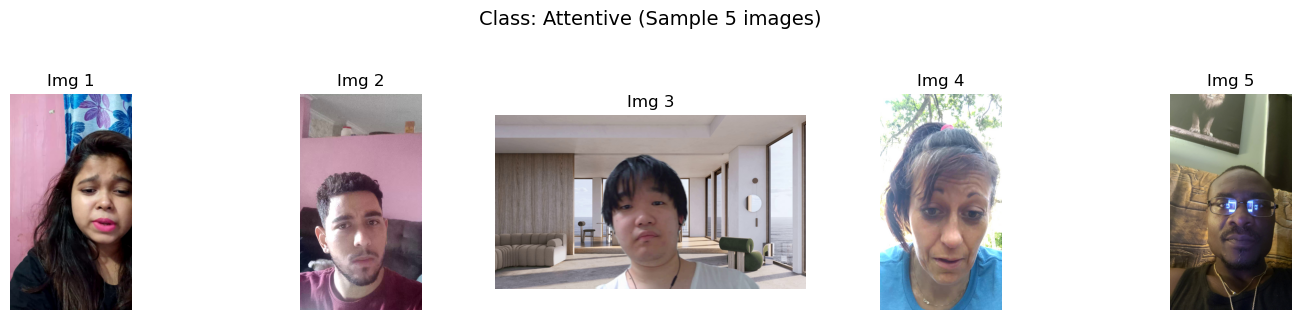

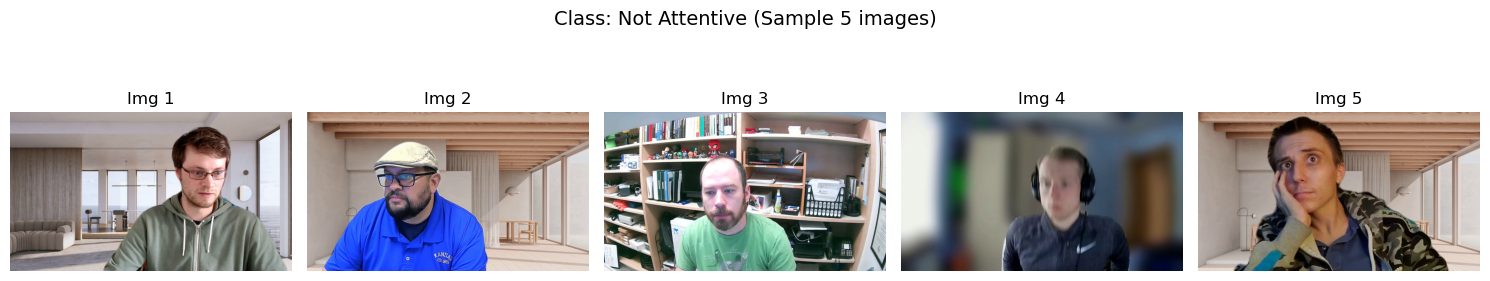

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image

# Load your CSV file
df = pd.read_csv('./HL_all_attention_results.csv')  

# Check the column names to ensure they match
print("Columns in your CSV:", df.columns.tolist())

# Function to display sample images from each class
def display_class_samples(class_name, num_samples=5):
    # Filter images by class
    class_samples = df[df['Human Label'] == class_name].sample(n=num_samples)

    # Create figure
    plt.figure(figsize=(15, 3))
    plt.suptitle(f'Class: {class_name} (Sample {num_samples} images)', fontsize=14, y=1.05)

    # Display each image
    for idx, (_, row) in enumerate(class_samples.iterrows()):
        img_path = row['Image Path']

        # Check if file exists
        if not os.path.exists(img_path):
            print(f"Warning: File not found - {img_path}")
            continue

        try:
            img = Image.open(img_path)
            plt.subplot(1, num_samples, idx+1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(f"Img {idx+1}")
        except Exception as e:
            print(f"Error loading image {img_path}: {str(e)}")

    plt.tight_layout()
    plt.show()

# Get unique classes from your dataset
classes = df['Human Label'].unique()
print("Classes in dataset:", classes)

# Display samples for each class
for class_name in classes:
    display_class_samples(class_name, num_samples=5)  # Change 5 to any number up to 10

# Preprocessing of data

In [16]:
import pandas as pd
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch



In [17]:
df.columns

Index(['Serial No', 'Image Name', 'Computer Label', 'Image Path', 'Drive URL',
       'Image Preview', 'Human Label'],
      dtype='object')

**As a part of pre processing needs to Encode labels: Attentive → 1, Not Attentive → 0**

In [18]:
# Encode labels: Attentive → 1, Not Attentive → 0
# df['label'] = df['Human Label'].map({'Attentive': 1, 'Not Attentive': 0})
df['label'] = df['Computer Label'].map({'Attentive': 1, 'Not Attentive': 0})
print(df['label'].value_counts())

label
1    1342
0    1058
Name: count, dtype: int64


**It has been observed as imbalance dataset, need to balance the dataset.**

In [19]:
# import pandas as pd

# df_1 = df[df['label'] == 1].sample(n=750, random_state=42)
# df_0 = df[df['label'] == 0].sample(n=750, random_state=42)

# # Concatenate the balanced samples
# df_balanced = pd.concat([df_1, df_0]).sample(frac=1, random_state=42).reset_index(drop=True)

# # Verify the result
# print(df_balanced['label'].value_counts())
# print(df_balanced.shape)

In [20]:
df_balanced = df
df_balanced.head()

Serial No                                         Image Name  \
0          1  78236e192c1171c149c14253a66ea628_1920x1080_30_...   
1          2  4d8ffedc816b405fe0187bd03392664f_1920x1080_30_...   
2          3  f7fe11d9c406c810f79b21e8c793bb99_1080x1920_30_...   
3          4  6c9c96d33030b3b3879c691760492b14_1920x1080_30_...   
4          5  3bcfd30cdb997ccb70af3559078a6ccc_1920x1080_30_...   

  Computer Label                                         Image Path  \
0      Attentive  ./dataset/All_extracted_frames/78236e192c1171c...   
1  Not Attentive  ./dataset/All_extracted_frames/4d8ffedc816b405...   
2      Attentive  ./dataset/All_extracted_frames/f7fe11d9c406c81...   
3  Not Attentive  ./dataset/All_extracted_frames/6c9c96d33030b3b...   
4  Not Attentive  ./dataset/All_extracted_frames/3bcfd30cdb997cc...   

                                           Drive URL  Image Preview  \
0  https://drive.google.com/uc?export=view&id=1ZW...            NaN   
1  https://drive.google.com/uc?export=view&id=1Iq...            NaN   
2  https://drive.google.com/uc?export=view&id=1nQ...            NaN   
3  https://drive.google.com/uc?export=view&id=1uA...            NaN   
4  https://drive.google.com/uc?export=view&id=1TZ...            NaN   

     Human Label  label  
0      Attentive      1  
1  Not Attentive      0  
2      Attentive      1  
3      Attentive      0  
4      Attentive      0

**Splitting the data into training set, validation set, testing set.**

In [21]:

# Split into train+val (80%) and test (20%)
train_val_df, test_df = train_test_split(
    df_balanced, test_size=0.2, stratify=df_balanced['label'], random_state=42
)

# Split train_val into train (70%) and val (10%)
train_df, val_df = train_test_split(
    train_val_df, test_size=0.125, stratify=train_val_df['label'], random_state=42
)  # 0.125 of 80% = 10%

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")


Train: 1680, Val: 240, Test: 480


# Custom Dataset Class to prepare a dataset

In [22]:
class AttentionDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image_path = self.dataframe.iloc[idx]['Image Path']
        label = self.dataframe.iloc[idx]['label']
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.float32)


**Preprocssing of dataset**
- Resizing the image to (224,224)
- Random Horizontal Flip
- tranforming to Tensor
- Normalizing the dataset

In [23]:
# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = AttentionDataset(train_df, transform=transform)
val_dataset = AttentionDataset(val_df, transform=transform)
test_dataset = AttentionDataset(test_df, transform=transform)



In [24]:
print(len(train_df))
train_df.head()
train_df['label'].value_counts()

1680


label
1    940
0    740
Name: count, dtype: int64

In [25]:
train_dataset[0]

(tensor([[[0.6745, 0.6745, 0.6784,  ..., 0.6196, 0.6196, 0.6196],
          [0.6667, 0.6706, 0.6784,  ..., 0.6196, 0.6196, 0.6196],
          [0.6667, 0.6667, 0.6667,  ..., 0.6196, 0.6196, 0.6196],
          ...,
          [0.8941, 0.8902, 0.8941,  ..., 0.4784, 0.4824, 0.4980],
          [0.8941, 0.8902, 0.8902,  ..., 0.4667, 0.4706, 0.4863],
          [0.8941, 0.8902, 0.8941,  ..., 0.4667, 0.4627, 0.4588]],
 
         [[0.6235, 0.6235, 0.6275,  ..., 0.5804, 0.5804, 0.5804],
          [0.6157, 0.6196, 0.6275,  ..., 0.5804, 0.5804, 0.5804],
          [0.6157, 0.6157, 0.6157,  ..., 0.5804, 0.5804, 0.5804],
          ...,
          [0.8627, 0.8588, 0.8627,  ..., 0.4667, 0.4706, 0.4863],
          [0.8667, 0.8627, 0.8588,  ..., 0.4549, 0.4588, 0.4745],
          [0.8706, 0.8627, 0.8627,  ..., 0.4549, 0.4510, 0.4471]],
 
         [[0.6000, 0.6000, 0.6039,  ..., 0.5843, 0.5843, 0.5843],
          [0.5922, 0.5961, 0.6039,  ..., 0.5843, 0.5843, 0.5843],
          [0.5922, 0.5922, 0.5922,  ...,

In [26]:
train_dataset[0][0].shape

torch.Size([3, 224, 224])

In [27]:
x, y = train_dataset[0]
print(y)

tensor(1.)


**Created a dataloader with batch size = 32**

In [28]:

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [29]:
print(len(train_loader)) # len(train_df) / batch_size
print(len(val_loader))
print(len(test_loader))

53
8
15


**Visualizing the transformed data which is loaded to an Dataloader**

Labels: ['Not Attentive', 'Not Attentive', 'Not Attentive', 'Attentive', 'Not Attentive', 'Attentive', 'Attentive', 'Attentive']


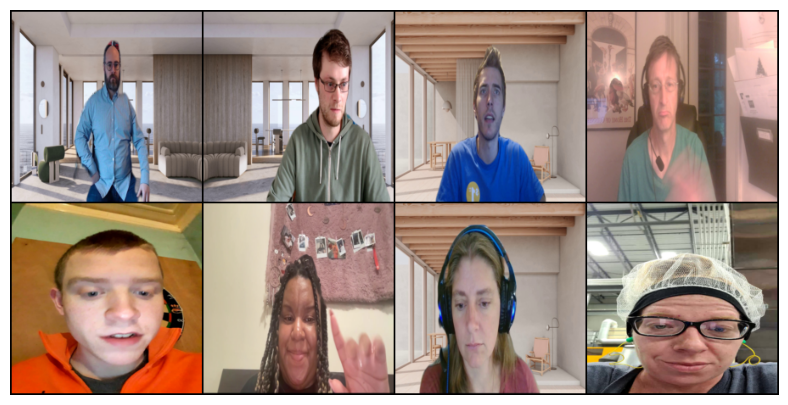

In [30]:
import matplotlib.pyplot as plt
import torchvision

# Function to display a batch of images with labels
def show_images(dataloader, class_names=["Not Attentive", "Attentive"]):
    # Get one batch
    images, labels = next(iter(dataloader))

    # Make a grid of images
    img_grid = torchvision.utils.make_grid(images[:8], nrow=4)  # show 8 images in 2 rows
    img_np = img_grid.permute(1, 2, 0).numpy()  # Convert from Tensor format

    plt.figure(figsize=(10, 5))
    plt.imshow(img_np)
    plt.axis('off')

    # Print labels
    labels = labels[:8].int().numpy()
    label_names = [class_names[label] for label in labels]
    print("Labels:", label_names)

# Call the function to show a few training samples
show_images(train_loader)


# Custom CNN Architecture

In [31]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 54 * 54, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # (batch, 16, 111, 111)
        x = self.pool(F.relu(self.conv2(x)))  # (batch, 32, 54, 54)
        x = x.view(-1, 32 * 54 * 54)
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x


In [32]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SimpleCNN().to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


# Training the model using CustomCNN 

Using device: cuda
Epoch 1/50 | Train Loss: 0.7190, Val Loss: 0.6484 | Train Acc: 0.5482, Val Acc: 0.6083
Epoch 2/50 | Train Loss: 0.6155, Val Loss: 0.5855 | Train Acc: 0.6637, Val Acc: 0.7208
Epoch 3/50 | Train Loss: 0.4990, Val Loss: 0.4699 | Train Acc: 0.7625, Val Acc: 0.7958
Epoch 4/50 | Train Loss: 0.4206, Val Loss: 0.4114 | Train Acc: 0.8024, Val Acc: 0.8167
Epoch 5/50 | Train Loss: 0.3657, Val Loss: 0.4037 | Train Acc: 0.8405, Val Acc: 0.8375
Epoch 6/50 | Train Loss: 0.3291, Val Loss: 0.3805 | Train Acc: 0.8649, Val Acc: 0.8458
Epoch 7/50 | Train Loss: 0.3189, Val Loss: 0.3577 | Train Acc: 0.8565, Val Acc: 0.8625
Epoch 8/50 | Train Loss: 0.2615, Val Loss: 0.3744 | Train Acc: 0.8899, Val Acc: 0.8542
Epoch 9/50 | Train Loss: 0.2355, Val Loss: 0.3226 | Train Acc: 0.9083, Val Acc: 0.8625
Epoch 10/50 | Train Loss: 0.2041, Val Loss: 0.3901 | Train Acc: 0.9274, Val Acc: 0.8458
Epoch 11/50 | Train Loss: 0.2047, Val Loss: 0.4418 | Train Acc: 0.9238, Val Acc: 0.8375
Epoch 12/50 | Train Lo

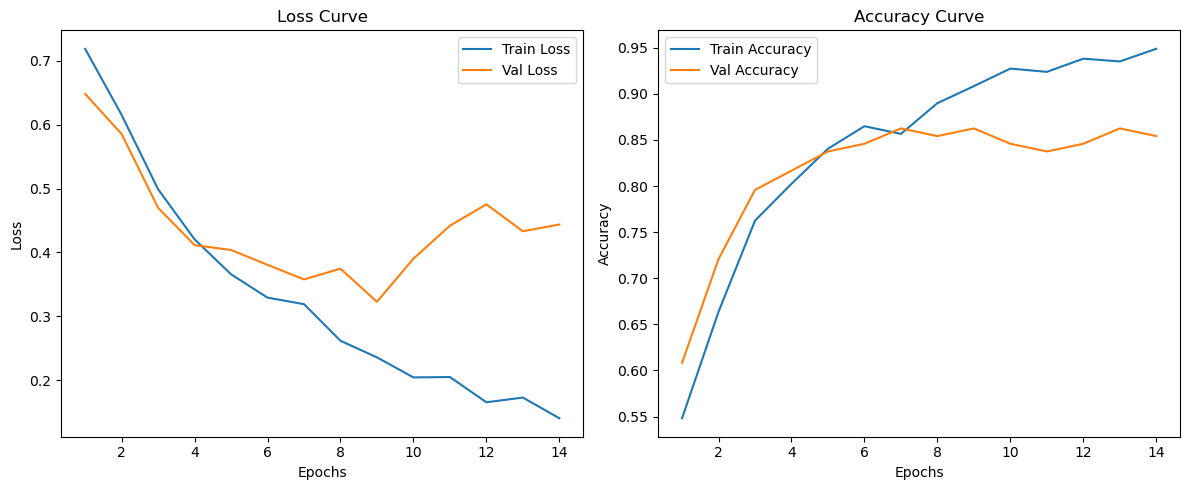

In [33]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Create model
customCNNmodel = SimpleCNN().to(device)

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(customCNNmodel.parameters(), lr=0.001)

# Training config
num_epochs = 50
patience = 5  # for early stopping
best_val_loss = float('inf')
early_stop_counter = 0

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Save directory
os.makedirs("models", exist_ok=True)
model_path = "models/CL_customCNNmodel.pth"

# Training loop
for epoch in range(num_epochs):
    customCNNmodel.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.float().to(device).unsqueeze(1)
        optimizer.zero_grad()
        outputs = customCNNmodel(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        preds = (outputs > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation
    customCNNmodel.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.float().to(device).unsqueeze(1)
            outputs = customCNNmodel(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds = (outputs > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss /= len(val_loader)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f} | Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        torch.save(customCNNmodel.state_dict(), model_path)  # Save best model
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping triggered.")
            break


# Load best model
customCNNmodel.load_state_dict(torch.load("models/CL_customCNNmodel.pth"))

# Plot loss and accuracy
epochs_range = range(1, len(train_losses) + 1)
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
plt.plot(epochs_range, val_accuracies, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()


In [34]:
# Save final model (for inference)
torch.save(customCNNmodel.state_dict(), "models/CL_customCNNmodel.pth")  # Save entire model object

In [35]:
# customCNNmodel

In [36]:
customCNNmodel = SimpleCNN().to(device)
customCNNmodel.load_state_dict(torch.load("models/CL_customCNNmodel.pth"))


<All keys matched successfully>

In [37]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# customCNNmodel = torch.load("models/HL_customCNNmodel.pt")

# customCNNmodel.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = customCNNmodel(images)
        preds = (outputs.cpu().numpy() > 0.5).astype(int).flatten()
        y_pred.extend(preds)
        y_true.extend(labels.numpy())

print('Accuracy:', accuracy_score(y_true, y_pred))
print('Precision:', precision_score(y_true, y_pred))
print('Recall:', recall_score(y_true, y_pred))
print('F1-score:', f1_score(y_true, y_pred))
print('Confusion Matrix:\n', confusion_matrix(y_true, y_pred))


Accuracy: 0.80625
Precision: 0.8228782287822878
Recall: 0.832089552238806
F1-score: 0.8274582560296846
Confusion Matrix:
 [[164  48]
 [ 45 223]]


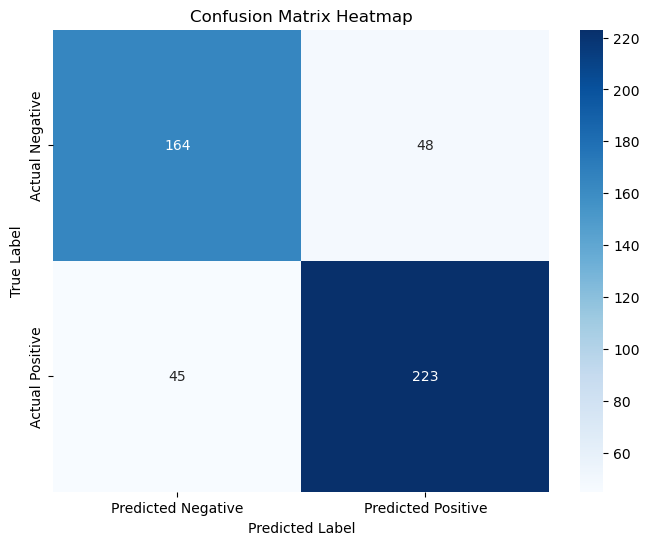

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Create heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

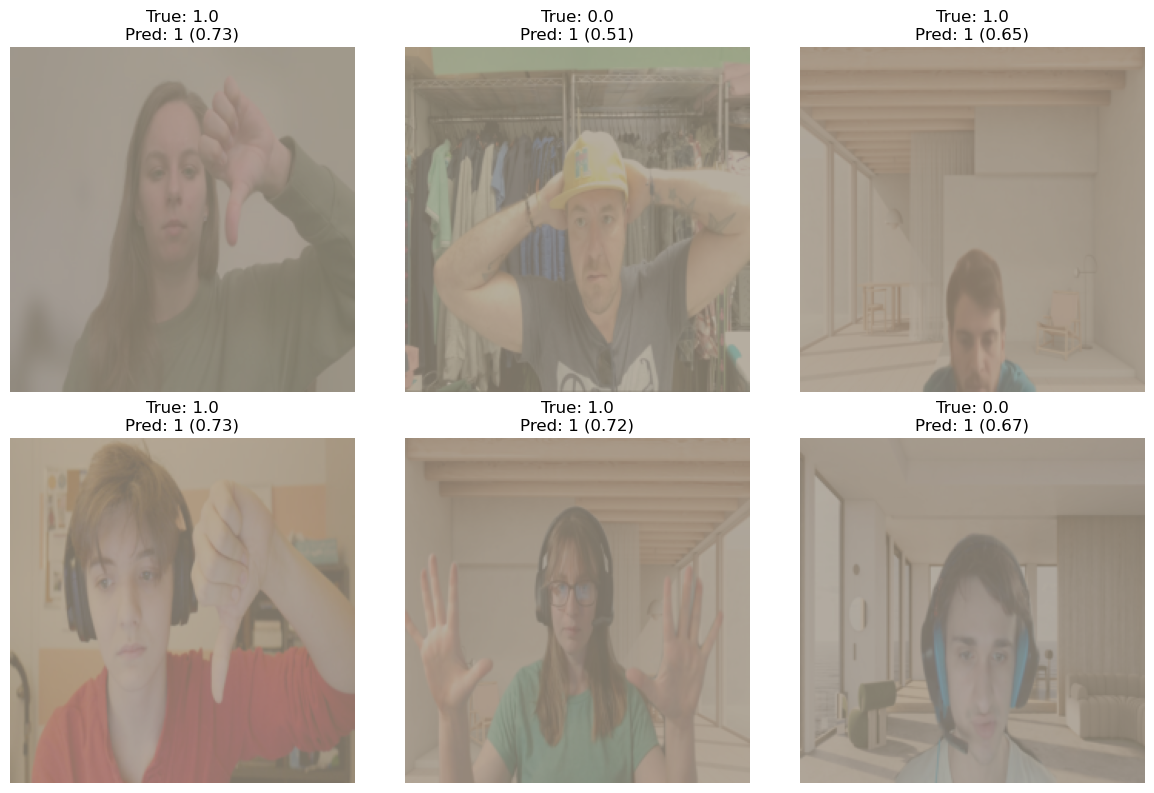

In [52]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# Function to show images from test_loader
def show_test_images(test_loader, model, device, num_images=6):
    # Get a batch of test images
    images, labels = next(iter(test_loader))

    # Move images to device and get predictions
    images = images.to(device)
    with torch.no_grad():
        outputs = model(images)
        probs = torch.sigmoid(outputs).cpu().numpy().flatten()
        preds = (probs > 0.5).astype(int)

    # Convert images back to CPU and denormalize if needed
    images = images.cpu()

    # Create a grid of images
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    axes = axes.ravel()

    for i in range(min(num_images, len(images))):
        # Denormalize if you used normalization in transforms
        img = images[i].numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean  # Denormalize
        img = np.clip(img, 0, 1)

        # Display image
        axes[i].imshow(img)
        axes[i].set_title(f"True: {labels[i].item()}\nPred: {preds[i]} ({probs[i]:.2f})")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Usage
show_test_images(test_loader, customCNNmodel, device)

# RESNET-18

Using device: cuda


C:\Users\spdsp\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\spdsp\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/50 | Train Loss: 0.6416, Val Loss: 0.6404 | Train Acc: 0.6238, Val Acc: 0.6417
Epoch 2/50 | Train Loss: 0.5820, Val Loss: 0.5544 | Train Acc: 0.6893, Val Acc: 0.6875
Epoch 3/50 | Train Loss: 0.5520, Val Loss: 0.5417 | Train Acc: 0.7202, Val Acc: 0.7000
Epoch 4/50 | Train Loss: 0.5251, Val Loss: 0.5492 | Train Acc: 0.7399, Val Acc: 0.6917
Epoch 5/50 | Train Loss: 0.5155, Val Loss: 0.5664 | Train Acc: 0.7393, Val Acc: 0.7000
Epoch 6/50 | Train Loss: 0.4957, Val Loss: 0.5214 | Train Acc: 0.7661, Val Acc: 0.7208
Epoch 7/50 | Train Loss: 0.5005, Val Loss: 0.5183 | Train Acc: 0.7589, Val Acc: 0.7500
Epoch 8/50 | Train Loss: 0.4846, Val Loss: 0.5089 | Train Acc: 0.7696, Val Acc: 0.7625
Epoch 9/50 | Train Loss: 0.4791, Val Loss: 0.5157 | Train Acc: 0.7768, Val Acc: 0.7583
Epoch 10/50 | Train Loss: 0.4909, Val Loss: 0.5393 | Train Acc: 0.7679, Val Acc: 0.7417
Epoch 11/50 | Train Loss: 0.4731, Val Loss: 0.4918 | Train Acc: 0.7827, Val Acc: 0.7708
Epoch 12/50 | Train Loss: 0.4669, Val Los

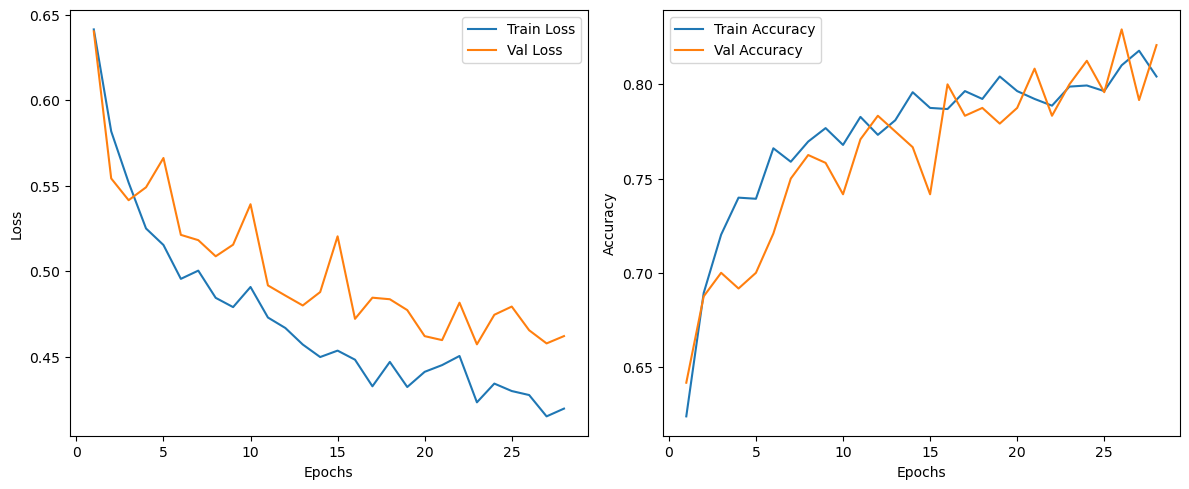

In [39]:
import torch
import torch.nn as nn
import torchvision.models as pretrain_models  # For pre-trained models
import matplotlib.pyplot as plt
import os

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# --- Load Pre-trained ResNet18 ---
resnet18_model = pretrain_models.resnet18(pretrained=True)

# Freeze all layers by default (optional: unfreeze later for fine-tuning)
for param in resnet18_model.parameters():
    param.requires_grad = False

# Replace the final fully connected layer for binary classification
num_features = resnet18_model.fc.in_features
resnet18_model.fc = nn.Sequential(
    nn.Linear(num_features, 1),  # Single output neuron
    nn.Sigmoid()  # Sigmoid for binary probability
)
resnet18_model = resnet18_model.to(device)

# Loss and optimizer (use BCEWithLogitsLoss if you remove Sigmoid)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(resnet18_model.parameters(), lr=0.001)

# --- Training Config (Unchanged) ---
num_epochs = 50
patience = 5
best_val_loss = float('inf')
early_stop_counter = 0

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Save directory
os.makedirs("models", exist_ok=True)
resnet18_model_path = "models/CL_resnet18_model.pth"

# --- Training Loop (Updated Variable Names) ---
for epoch in range(num_epochs):
    resnet18_model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.float().to(device).unsqueeze(1)
        optimizer.zero_grad()
        outputs = resnet18_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        preds = (outputs > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation
    resnet18_model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.float().to(device).unsqueeze(1)
            outputs = resnet18_model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds = (outputs > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss /= len(val_loader)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f} | Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        torch.save(resnet18_model.state_dict(), resnet18_model_path)
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping triggered.")
            break

# Load best model
resnet18_model.load_state_dict(torch.load(resnet18_model_path))

# --- Plotting (Unchanged) ---
epochs_range = range(1, len(train_losses) + 1)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
plt.plot(epochs_range, val_accuracies, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [40]:
# Save final model
torch.save(resnet18_model.state_dict(), "models/CL_Resnet18_model.pth")

In [41]:
# resnet18_model

In [43]:
import torch
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision.models as pretrain_models  # For pre-trained models

# 1. Load the trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet18_model = pretrain_models.resnet18(pretrained=False)
num_features = resnet18_model.fc.in_features
resnet18_model.fc = nn.Sequential(  # ← Key fix
    nn.Linear(num_features, 1),
    nn.Sigmoid()  # Add this if your saved model had it
)
resnet18_model.load_state_dict(torch.load("models/CL_Resnet18_model.pth", map_location=device))
resnet18_model = resnet18_model.to(device)
resnet18_model.eval()

C:\Users\spdsp\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\spdsp\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [44]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

# # Load the trained ResNet18 model
# resnet18_model.load_state_dict(torch.load("models/CL_resnet18_model.pth"))
# resnet18_model.eval()

y_true, y_pred, y_probs = [], [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.numpy()  # Move to CPU immediately

        # Forward pass
        outputs = resnet18_model(images)
        # print(outputs)
        probs = outputs.cpu().numpy().flatten()
        # print(probs)
        preds = (probs > 0.5).astype(int)  # Threshold at 0.5
        # print(preds)

        # Store results
        y_true.extend(labels)
        y_pred.extend(preds)
        y_probs.extend(probs)  # Useful for ROC curves later

# Calculate metrics
print('=== Evaluation Metrics ===')
print('Accuracy:', accuracy_score(y_true, y_pred))
print('Precision:', precision_score(y_true, y_pred))
print('Recall:', recall_score(y_true, y_pred))
print('F1-score:', f1_score(y_true, y_pred))
print('Confusion Matrix:\n', confusion_matrix(y_true, y_pred))

# Optional: Class-wise metrics (if classes are imbalanced)
print('\n=== Class-wise Metrics ===')
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
print('Class 0 (True Negatives):', tn)
print('Class 1 (True Positives):', tp)
print('False Positives (Type I):', fp)
print('False Negatives (Type II):', fn)

=== Evaluation Metrics ===
Accuracy: 0.7895833333333333
Precision: 0.8249027237354085
Recall: 0.7910447761194029
F1-score: 0.8076190476190476
Confusion Matrix:
 [[167  45]
 [ 56 212]]

=== Class-wise Metrics ===
Class 0 (True Negatives): 167
Class 1 (True Positives): 212
False Positives (Type I): 45
False Negatives (Type II): 56


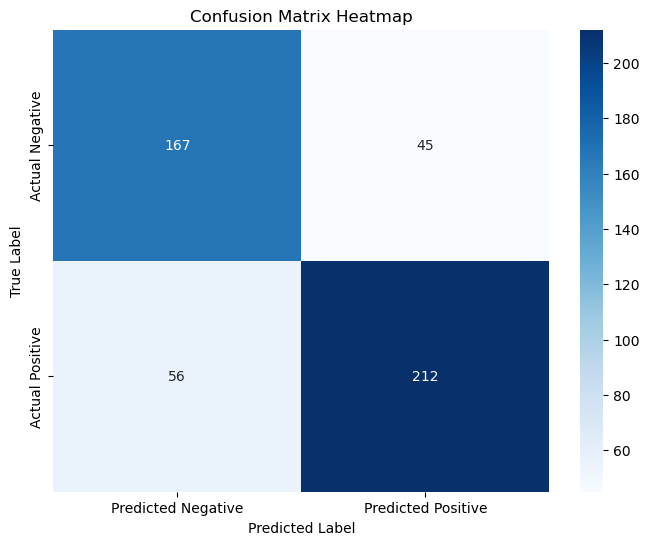

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Create heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

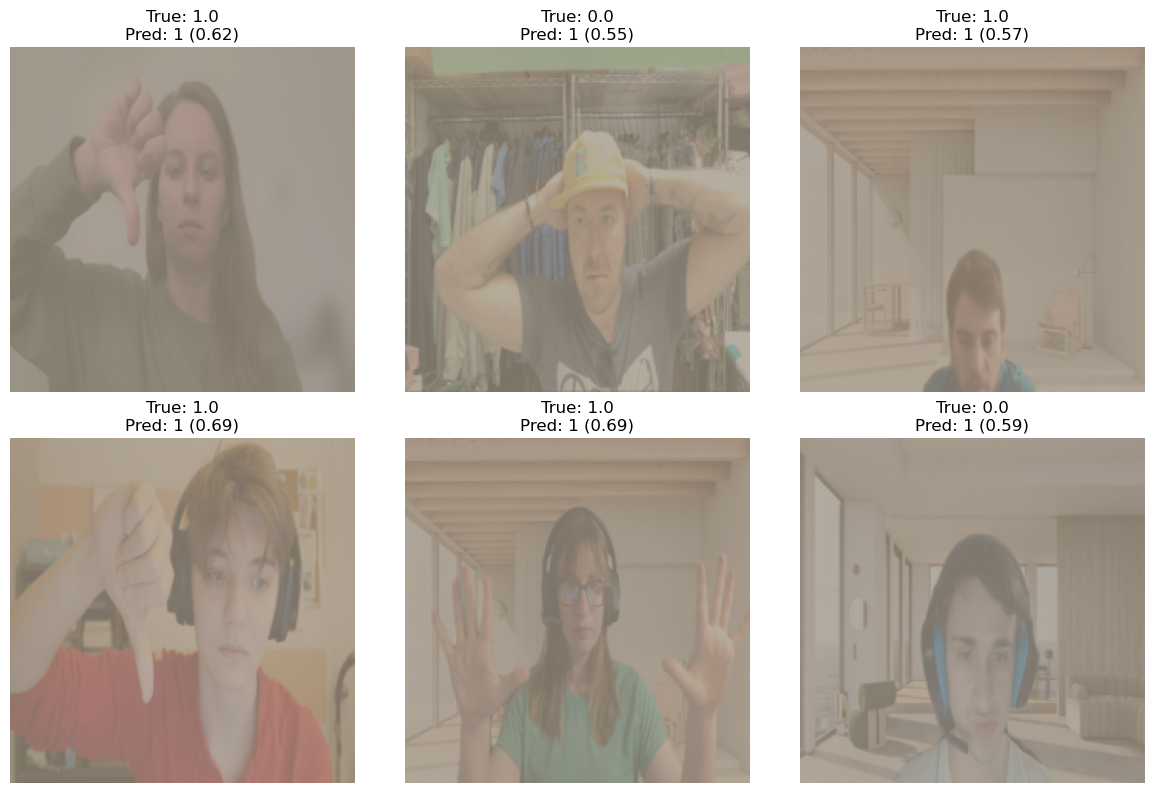

In [46]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# Function to show images from test_loader
def show_test_images(test_loader, model, device, num_images=6):
    # Get a batch of test images
    images, labels = next(iter(test_loader))

    # Move images to device and get predictions
    images = images.to(device)
    with torch.no_grad():
        outputs = model(images)
        probs = torch.sigmoid(outputs).cpu().numpy().flatten()
        preds = (probs > 0.5).astype(int)

    # Convert images back to CPU and denormalize if needed
    images = images.cpu()

    # Create a grid of images
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    axes = axes.ravel()

    for i in range(min(num_images, len(images))):
        # Denormalize if you used normalization in transforms
        img = images[i].numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean  # Denormalize
        img = np.clip(img, 0, 1)

        # Display image
        axes[i].imshow(img)
        axes[i].set_title(f"True: {labels[i].item()}\nPred: {preds[i]} ({probs[i]:.2f})")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Usage
show_test_images(test_loader, resnet18_model, device)

# VGG-19

Using device: cuda


C:\Users\spdsp\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\spdsp\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to C:\Users\spdsp/.cache\torch\hub\checkpoints\vgg19-dcbb9e9d.pth
IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate

Epoch 1/50 | Train Loss: 0.6029, Val Loss: 0.5485 | Train Acc: 0.6548, Val Acc: 0.7000
Epoch 2/50 | Train Loss: 0.5471, Val Loss: 0.5666 | Train Acc: 0.7238, Val Acc: 0.7167
Epoch 3/50 | Train Loss: 0.5076, Val Loss: 0.5038 | Train Acc: 0.7536, Val Acc: 0.7708
Epoch 4/50 | Train Loss: 0.4988, Val Loss: 0.5308 | Train Acc: 0.7655, Val Acc: 0.7125
Epoch 5/50 | Train Loss: 0.5026, Val Loss: 0.4828 | Train Acc: 0.7595, Val Acc: 0.7875
Epoch 6/50 | Train Loss: 0.4826, Val Loss: 0.4868 | Train Acc: 0.7774, Val Acc: 0.7417
Epoch 7/50 | Train Loss: 0.4644, Val Loss: 0.4751 | Train Acc: 0.7875, Val Acc: 0.7500
Epoch 8/50 | Train Loss: 0.4668, Val Loss: 0.4718 | Train Acc: 0.7792, Val Acc: 0.7667
Epoch 9/50 | Train Loss: 0.4512, Val Loss: 0.4487 | Train Acc: 0.7798, Val Acc: 0.7917
Epoch 10/50 | Train Loss: 0.4562, Val Loss: 0.4502 | Train Acc: 0.7887, Val Acc: 0.7750
Epoch 11/50 | Train Loss: 0.4493, Val Loss: 0.4383 | Train Acc: 0.7851, Val Acc: 0.8083
Epoch 12/50 | Train Loss: 0.4406, Val Los

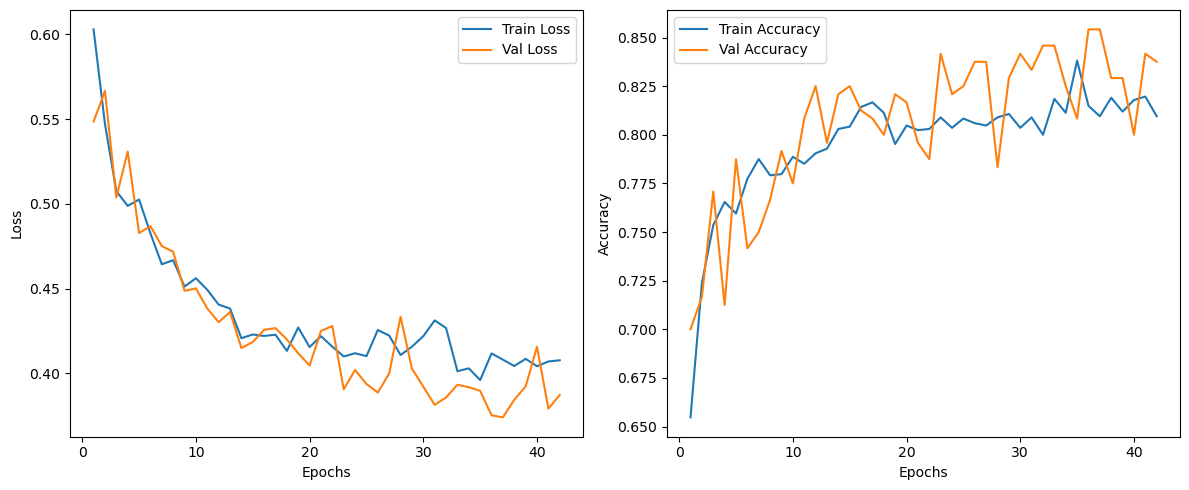

In [48]:
import torch
import torch.nn as nn
import torchvision.models as pretrain_models
import matplotlib.pyplot as plt
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


# ---------------------------------------------------------------------------
# --- Load Pre-trained VGG19 ---
vgg19_model = pretrain_models.vgg19(pretrained=True)

# Freeze all layers by default (optional: unfreeze later for fine-tuning)
for param in vgg19_model.parameters():
    param.requires_grad = False

# Modify the classifier for binary classification
# Original VGG19 has 1000 output features (for ImageNet)
num_features = vgg19_model.classifier[6].in_features
vgg19_model.classifier[6] = nn.Sequential(
    nn.Linear(num_features, 1),  # Single output neuron
    nn.Sigmoid()  # Sigmoid for binary probability
)
vgg19_model = vgg19_model.to(device)


# -------------------------------------------------------------------------
# Loss and optimizer (use BCEWithLogitsLoss if you remove Sigmoid)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(vgg19_model.parameters(), lr=0.001)

# --- Training Config ---
num_epochs = 50
patience = 5
best_val_loss = float('inf')
early_stop_counter = 0

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Save directory
os.makedirs("models", exist_ok=True)
vgg19_model_path = "models/CL_vgg19_model.pth"

# --- Training Loop ---
for epoch in range(num_epochs):
    vgg19_model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.float().to(device).unsqueeze(1)
        optimizer.zero_grad()
        outputs = vgg19_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        preds = (outputs > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation
    vgg19_model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.float().to(device).unsqueeze(1)
            outputs = vgg19_model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds = (outputs > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss /= len(val_loader)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f} | Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        torch.save(vgg19_model.state_dict(), vgg19_model_path)
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping triggered.")
            break

# Load best model
vgg19_model.load_state_dict(torch.load(vgg19_model_path))

# --- Plotting ---
epochs_range = range(1, len(train_losses) + 1)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
plt.plot(epochs_range, val_accuracies, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [49]:
# Save final model
torch.save(vgg19_model.state_dict(), "models/CL_vgg19_model.pth")

In [50]:

# ---------------------------------------------------------------------------
# --- Load Pre-trained VGG19 ---
vgg19_model = pretrain_models.vgg19(pretrained=True)

# Freeze all layers by default (optional: unfreeze later for fine-tuning)
for param in vgg19_model.parameters():
    param.requires_grad = False

# Modify the classifier for binary classification
# Original VGG19 has 1000 output features (for ImageNet)
num_features = vgg19_model.classifier[6].in_features
vgg19_model.classifier[6] = nn.Sequential(
    nn.Linear(num_features, 1),  # Single output neuron
    nn.Sigmoid()  # Sigmoid for binary probability
)
vgg19_model.load_state_dict(torch.load("models/CL_vgg19_model.pth", map_location=device))
vgg19_model = vgg19_model.to(device)
vgg19_model.eval()


# --- Evaluation on Test Set ---
# vgg19_model.eval()
y_true, y_pred, y_probs = [], [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.numpy()

        outputs = vgg19_model(images)
        probs = outputs.cpu().numpy().flatten()
        preds = (probs > 0.5).astype(int)

        y_true.extend(labels)
        y_pred.extend(preds)
        y_probs.extend(probs)

# Calculate metrics
print('=== Evaluation Metrics ===')
print('Accuracy:', accuracy_score(y_true, y_pred))
print('Precision:', precision_score(y_true, y_pred))
print('Recall:', recall_score(y_true, y_pred))
print('F1-score:', f1_score(y_true, y_pred))
print('Confusion Matrix:\n', confusion_matrix(y_true, y_pred))

# Class-wise metrics
print('\n=== Class-wise Metrics ===')
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
print('Class 0 (True Negatives):', tn)
print('Class 1 (True Positives):', tp)
print('False Positives (Type I):', fp)
print('False Negatives (Type II):', fn)

C:\Users\spdsp\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\spdsp\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


=== Evaluation Metrics ===
Accuracy: 0.8041666666666667
Precision: 0.848
Recall: 0.7910447761194029
F1-score: 0.8185328185328186
Confusion Matrix:
 [[174  38]
 [ 56 212]]

=== Class-wise Metrics ===
Class 0 (True Negatives): 174
Class 1 (True Positives): 212
False Positives (Type I): 38
False Negatives (Type II): 56


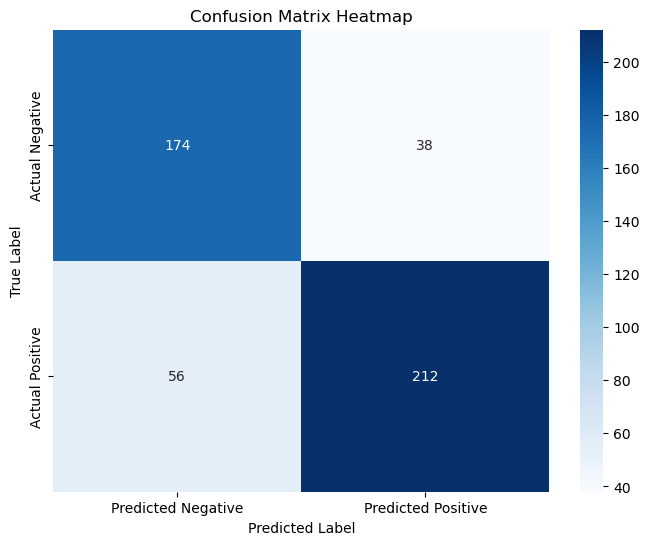

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Create heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

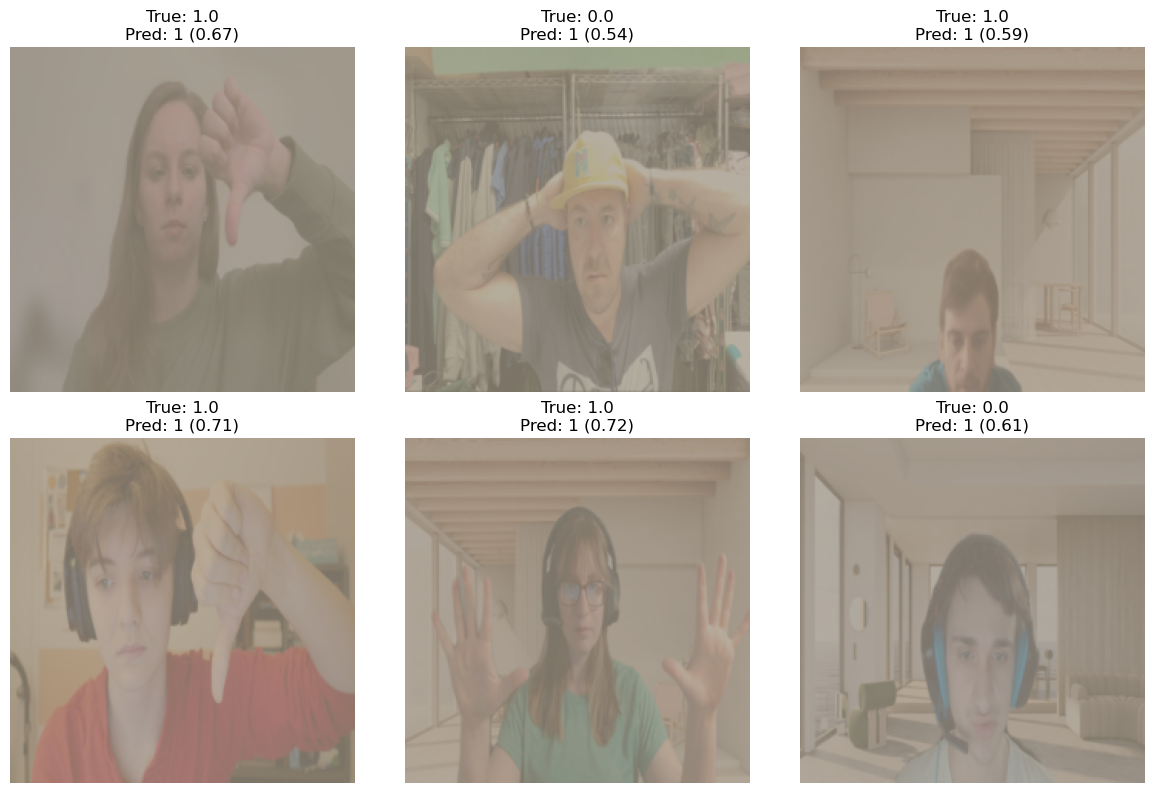

In [53]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# Function to show images from test_loader
def show_test_images(test_loader, model, device, num_images=6):
    # Get a batch of test images
    images, labels = next(iter(test_loader))

    # Move images to device and get predictions
    images = images.to(device)
    with torch.no_grad():
        outputs = model(images)
        probs = torch.sigmoid(outputs).cpu().numpy().flatten()
        preds = (probs > 0.5).astype(int)

    # Convert images back to CPU and denormalize if needed
    images = images.cpu()

    # Create a grid of images
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    axes = axes.ravel()

    for i in range(min(num_images, len(images))):
        # Denormalize if you used normalization in transforms
        img = images[i].numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean  # Denormalize
        img = np.clip(img, 0, 1)

        # Display image
        axes[i].imshow(img)
        axes[i].set_title(f"True: {labels[i].item()}\nPred: {preds[i]} ({probs[i]:.2f})")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Usage
show_test_images(test_loader, vgg19_model, device)

In [ ]:
# !pip install torchcam

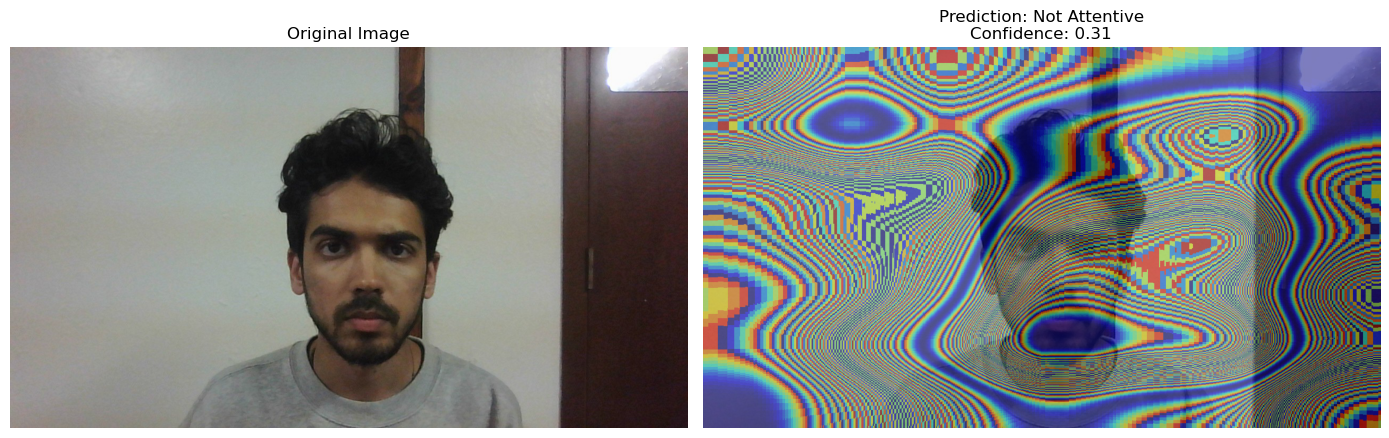

./2.jpg: Not Attentive (30.74%)
Error processing ./1.jpg: cannot register a hook on a tensor that doesn't require gradient


In [69]:
# import torch
# import torch.nn as nn
# from torchvision import models as pretrain_models
# from torchcam.methods import SmoothGradCAMpp
# from torchcam.utils import overlay_mask
# from PIL import Image
# import matplotlib.pyplot as plt
# import torchvision.transforms as transforms
# import warnings
# warnings.filterwarnings('ignore')

# # 1. Setup device and model
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Load the trained model
# resnet18_model = pretrain_models.resnet18(pretrained=False)
# num_features = resnet18_model.fc.in_features
# resnet18_model.fc = nn.Sequential(
#     nn.Linear(num_features, 1),
#     nn.Sigmoid()
# )
# resnet18_model.load_state_dict(torch.load("models/HL_Resnet18_model.pth", map_location=device))
# resnet18_model = resnet18_model.to(device)
# resnet18_model.eval()

# # 2. Image preprocessing pipeline with grayscale conversion to RGB
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.CenterCrop(224),
#     transforms.Grayscale(num_output_channels=3),  # Convert grayscale to 3-channel
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                         std=[0.229, 0.224, 0.225])
# ])

# # 3. Prediction with CAM visualization
# def predict_with_cam(image_path, threshold=0.5):
#     try:
#         # Load image and ensure RGB format
#         image = Image.open(image_path)
#         if image.mode != 'RGB':
#             image = image.convert('RGB')
            
#         img_tensor = transform(image).unsqueeze(0).to(device)
#         img_tensor.requires_grad_(True)
        
#         # Initialize CAM extractor
#         cam_extractor = SmoothGradCAMpp(resnet18_model)
        
#         # Forward pass with gradients
#         with torch.enable_grad():
#             output = resnet18_model(img_tensor)
#             prob = output.item()
#             pred = "Attentive" if prob > threshold else "Not Attentive"
            
#             # Get activation map
#             activation_map = cam_extractor(output.squeeze(0).argmax().item(), output)
        
#         # Create overlay
#         result = overlay_mask(
#             image, 
#             to_pil_image(activation_map[0].squeeze(0).detach().cpu()), 
#             alpha=0.5
#         )
        
#         # Visualization
#         fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
        
#         ax1.imshow(image)
#         ax1.set_title("Original Image")
#         ax1.axis('off')
        
#         ax2.imshow(result)
#         ax2.set_title(f"Prediction: {pred}\nConfidence: {prob:.2f}")
#         ax2.axis('off')
        
#         plt.tight_layout()
#         plt.show()
        
#         return pred, prob
    
#     except Exception as e:
#         print(f"Error processing {image_path}: {str(e)}")
#         return None, None
#     finally:
#         if 'img_tensor' in locals():
#             img_tensor.requires_grad_(False)

# # 4. Batch processing function
# def process_images(image_paths, threshold=0.5):
#     results = []
#     for path in image_paths:
#         pred, prob = predict_with_cam(path, threshold)
#         if pred is not None:
#             results.append((path, pred, prob))
#             print(f"{path}: {pred} ({prob:.2%})")
#     return results

# # Example usage
# if __name__ == "__main__":
#     image_list = [
#         "./2.jpg",
#         "./1.jpg",
#         # Add more images as needed
#     ]
    
#     results = process_images(image_list)